# Analyse results of hyperparameter search

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from model_functions import train_xgb_model_no_plot
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold

## Get data

In [2]:
# Type of features used in training
feature_scope = 'temp_prec' # Temperature and precipitation
#feature_scope = 'all_climate' # All climate data

# Path of cv results
training_path = '2023-09-18_12-21-53/temp_prec_' # 5 fold blocking by glacier, grid search with ~800 000 hyperparameter comb., temperature + precipitation + topographical features

In [3]:
# Specify filepaths and filenames.
loc = 'cluster'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'
elif loc == 'cluster':
    filepath = '/mirror/khsjursen/ML_MB_Norway/Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)

/tmp/ipykernel_49099/2984070557.py:14: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [4]:
# Get features and labels based on type of features used in training

# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

if feature_scope=='temp_prec':
    
    # Select features
    base_cols = ['altitude','aspect','slope','altitude_climate','lat','lon']
    temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
    prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
    label_cols = ['balance_netto']

    # Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
    df_train_s = df_train.sample(frac=1, random_state=5)
    df_train_s.reset_index(drop=True, inplace=True)

    # Select features for training
    df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)

    # Select labels for training
    df_train_y_s = select_variables(df_train_s, label_cols)
    X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

    
#elif feature_scope=='all_climate':

    # Select features to drop
#    cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
#            'location_description','location_id','stake_no','utm_east','utm_north',
#            'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
#            'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
#            'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
#            'topo','dis_from_border','year']

#    snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
#    snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
#    evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
#    snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
#    snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
#    snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
#    snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
#    snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
#    snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

#    drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

    # Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
#    df_train_s = df_train.sample(frac=1, random_state=5)
#    df_train_s.reset_index(drop=True, inplace=True)

    # Select features for training
#    df_train_X_s = df_train_s.drop(drop_cols, axis=1)

    # Select labels for training
#    df_train_y_s = df_train_s[['balance_netto']]
#    X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [5]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [6]:
print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Validation, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Validation, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Validation, fold 5:  [ 596 1144 2148 2514 3126 3128]


## Get grid search results

In [9]:
# Specify filepaths and filenames.
if loc == 'cryocloud':
    filepath_results = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath_results = 'Models/Block_glacier_5fold/'
elif loc == 'cluster':
    filepath_results = '/mirror/khsjursen/ML_MB_Norway/Models/Block_glacier_5fold/'    

In [10]:
# Get cv-grid
cv_grid = joblib.load(filepath_results + training_path + 'cv_grid.pkl')

# Get cv-scores
cv_scores = joblib.load(filepath_results + training_path + 'cv_scores.pkl')

# Get best model
best_model = joblib.load(filepath_results + training_path + 'cv_best_model.pkl')

In [11]:
cv_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_colsample_bytree', 'param_gamma', 'param_lambda', 'param_learning_rate', 'param_max_depth', 'param_min_child_weight', 'param_n_estimators', 'param_random_state', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [12]:
print('Best mean validation score: ', cv_grid.cv_results_['mean_test_score'].max())
print('Validation score per fold: ', cv_scores)
print('Check mean score: ', cv_scores.mean())
print('Standard deviation: ', cv_scores.std())

Best mean validation score:  -1.636428935757764
Validation score per fold:  [-1.71773752 -1.23221953 -1.83088134 -1.09783569 -2.3034706 ]
Check mean score:  -1.636428935757764
Standard deviation:  0.4342430967512608


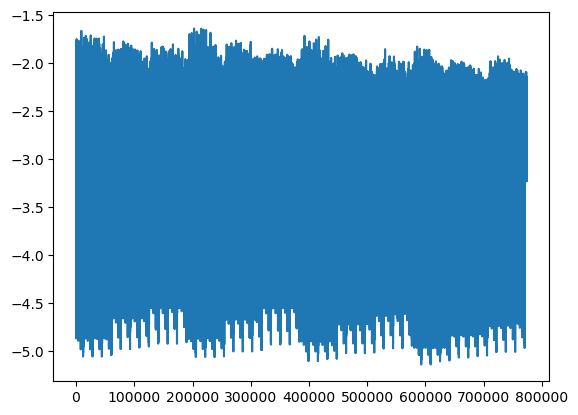

In [13]:
plt.plot(cv_grid.cv_results_['mean_test_score'])

In [14]:
cv_grid.best_params_

{'alpha': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'lambda': 5,
 'learning_rate': 0.15,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 400,
 'random_state': 23,
 'subsample': 0.5}

In [15]:
idx = np.argmin(cv_grid.cv_results_['rank_test_score'])
idx

202674

In [16]:
print('Validation score fold 0: ', cv_grid.cv_results_['split0_test_score'][idx])
print('Validation score fold 1: ', cv_grid.cv_results_['split1_test_score'][idx])
print('Validation score fold 2: ', cv_grid.cv_results_['split2_test_score'][idx])
print('Validation score fold 3: ', cv_grid.cv_results_['split3_test_score'][idx])
print('Validation score fold 4: ', cv_grid.cv_results_['split4_test_score'][idx])

Validation score fold 0:  -1.7177375204058558
Validation score fold 1:  -1.2322195281608117
Validation score fold 2:  -1.8308813391181382
Validation score fold 3:  -1.0978356902501327
Validation score fold 4:  -2.303470600853881


In [17]:
cv_grid.cv_results_['params'][idx]

{'alpha': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'lambda': 5,
 'learning_rate': 0.15,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 400,
 'random_state': 23,
 'subsample': 0.5}

In [18]:
best_model

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5, learning_rate=0.15,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None, ...)

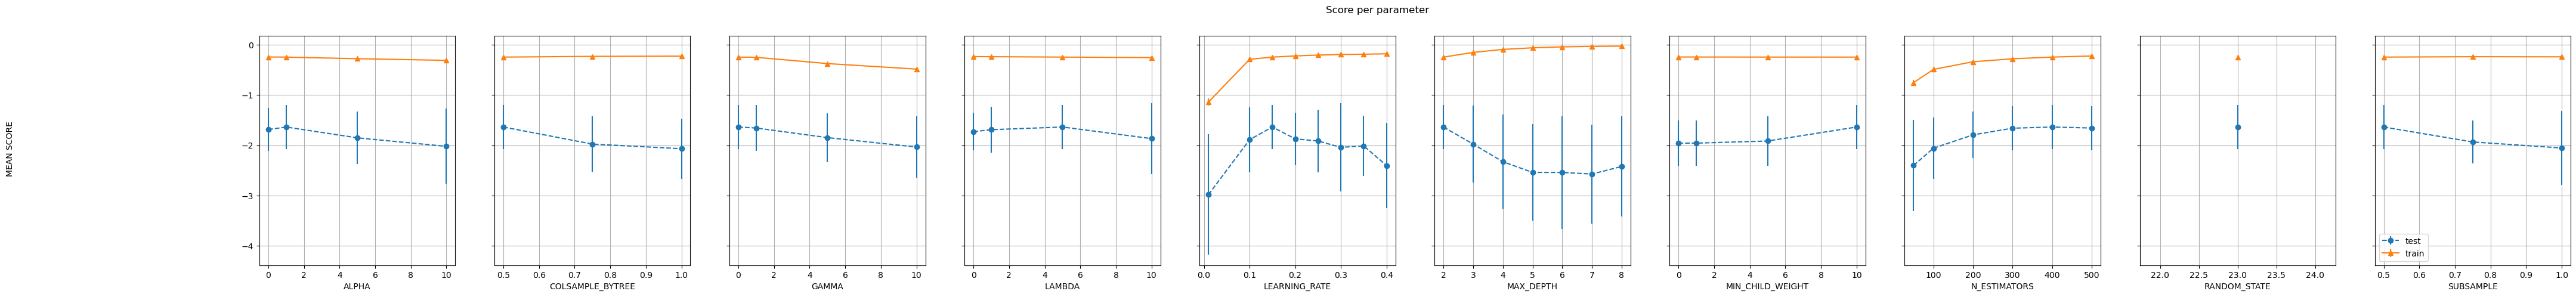

In [19]:
plot_gsearch_results(cv_grid)

min_child_weight parameter: "
Intuitively, this is the minimum number of samples that a node can represent in order to be split further. If there are fewer than min_child_weight samples at that node, the node becomes a leaf and is no longer split. This can help reduce the model complexity and prevent overfittin"

large min child weight with shallow trees??g.

In [20]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [21]:
from sklearn.model_selection import cross_val_score
cvl = cross_val_score(fitted_model, X_train_s, y_train_s, cv=splits_s, scoring='neg_mean_squared_error')
print(cvl)

In [115]:
#param_ranges = {'max_depth': [2], # Depth of tree
#                'n_estimators': [400], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.15], #[0,1]
#                'gamma': [0], # Regularization parameter [0,inf]
#                'lambda': [5], # Regularization [1,inf]
#                'alpha': [1], # Regularization [0,inf]
#                'colsample_bytree': [0.5], # (0,1]  A smaller colsample_bytree value results in smaller and less complex models, which can help prevent overfitting. It is common to set this value between 0.5 and 1.
#                'subsample': [0.5], # (0,1] common to set this value between 0.5 and 1
#                'min_child_weight': [10], # [0,inf]
#                'random_state': [0, 1, 2, 3, 4]
#               } 

#cv_grid_test, best_model_test, cvl_scores_test = train_xgb_model_no_plot(X_train_s, y_train_s, splits_s, param_ranges, n_jobs=40, scorer='neg_mean_squared_error')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [114]:
#print('Best mean validation score: ', cv_grid_test.cv_results_['mean_test_score'].max())
#print('Validation score per fold: ', cvl_scores_test)
#print('Check mean score: ', cvl_scores_test.mean())
#print('Standard deviation: ', cvl_scores_test.std())

Best mean validation score:  -1.9429728548317737
Validation score per fold:  [-1.74773446 -1.87597451 -2.32057812 -1.29174879 -2.4788284 ]
Check mean score:  -1.9429728548317737
Standard deviation:  0.4234209450016131


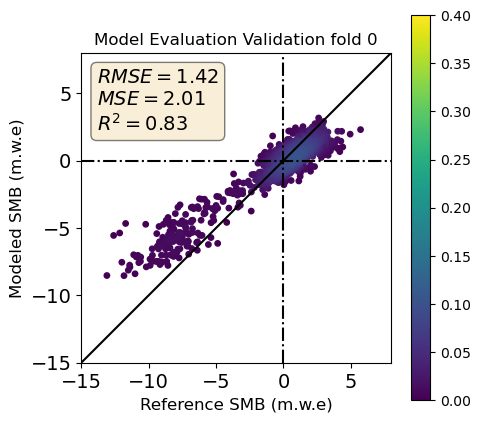

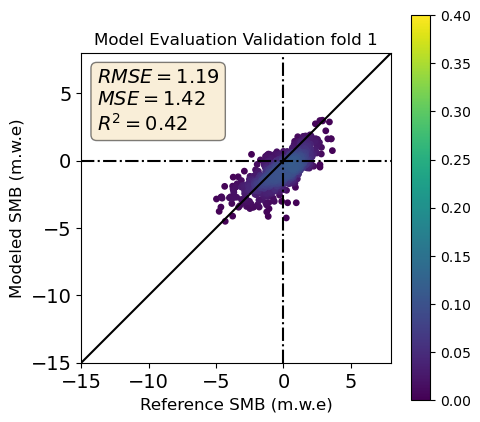

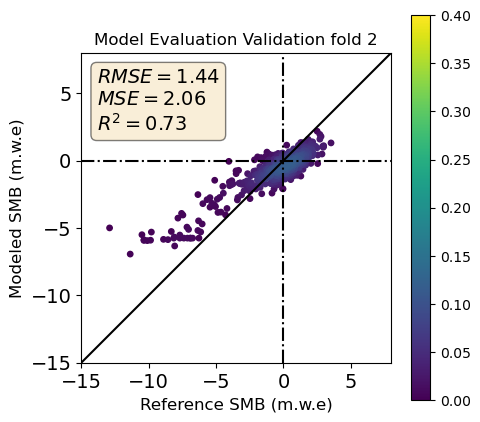

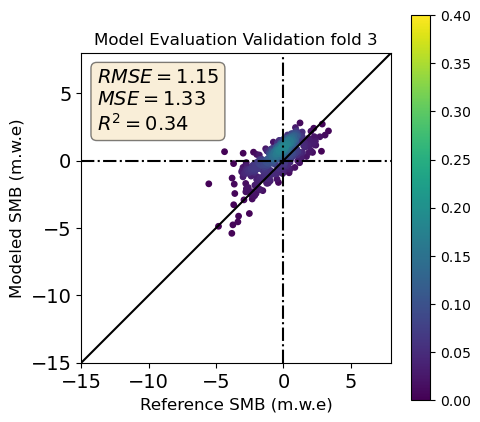

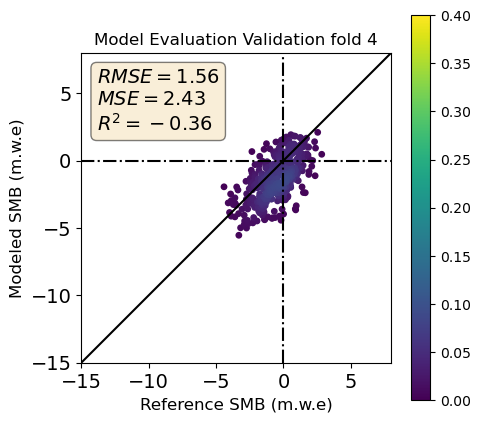

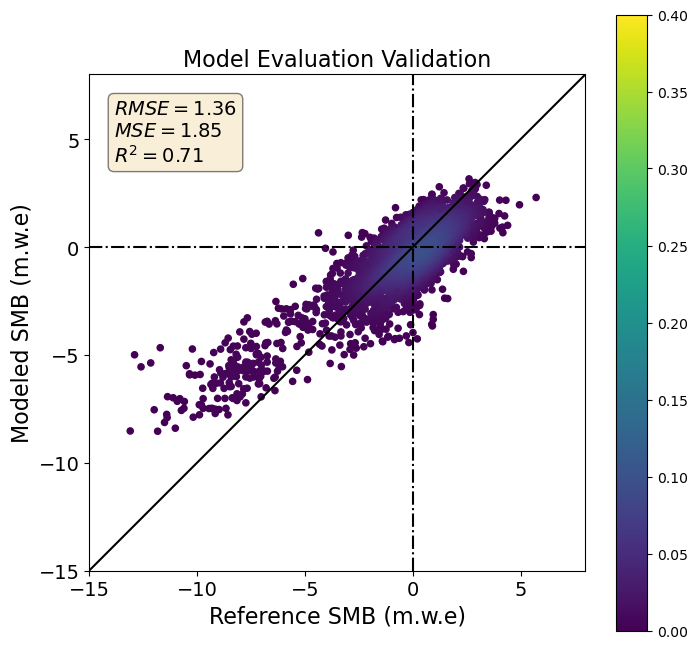

In [110]:
plot_prediction_per_fold(X_train_s, y_train_s, best_model, splits_s)